# Importacion del Dataset

In [1]:
import pandas as pd

 Las variables 'Watches', 'Likes', 'Fans' y 'Total_ratings' están fuertemente correlacionadas,
 por lo que todas miden esencialmente lo mismo: la popularidad de la película.
 Para simplificar el modelo y evitar redundancia, se decide utilizar únicamente 'Average_rating' 
 como representación de la popularidad.

 Además, se crea un rango o bin de valores de 'Average_rating' para:
 1) Mejorar la generalización del modelo.
 2) Mantener un balance más uniforme entre clases o grupos de popularidad.

In [2]:
df = pd.read_csv("datos/Letterbox Movie Classification Dataset.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Film_title,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,Fans,Lowest★,Medium★★★,Highest★★★★★,Total_ratings
0,The Fan,Eckhart Schmidt,3.57,"['Horror', 'Drama']",92.0,German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],12841,11032,3763,79,129,1660,714,9042
1,Mad Max: Fury Road,George Miller,4.18,"['Adventure', 'Science Fiction', 'Action']",121.0,English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",2488721,331681,927538,38000,12530,158356,511140,1682389
2,Suspiria,Dario Argento,3.93,['Horror'],99.0,English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],618171,220094,219548,13000,2814,53427,88628,443757
3,Lost in Translation,Sofia Coppola,3.79,"['Drama', 'Comedy', 'Romance']",102.0,English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']",1596190,254180,493248,38000,15167,155110,193717,1076949
4,Akira,Katsuhiro Otomo,4.28,"['Animation', 'Action', 'Science Fiction']",124.0,Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",873068,175586,341567,21000,1822,40850,196532,600721


# Preprocesamiento

#### Eliminacion de variables

In [3]:
df_movies = df.drop([
    'Watches', 'List_appearances', 'Likes', 'Fans', 'Lowest★', 'Medium★★★', 'Highest★★★★★', 'Total_ratings',
    'Film_title'
    ], axis=1)

#### `Sentiment`

Se crea una nueva columna 'Sentiment' en el DataFrame df_movies.

Para cada película, se toma el texto de la columna 'Description' y se calcula el "sentiment polarity" usando TextBlob.

El "sentiment polarity" devuelve un valor entre -1 y 1:
- -1  → sentimiento muy negativo
- 0  → sentimiento neutral
- +1  → sentimiento muy positivo

Como el rango original de polaridad ya está en [-1, 1], decidimos escalarlo a [0, 1] con MinMaxScaler para normalizarlo junto con otras variables numéricas del dataset.

De este modo, todas las features quedan en la misma escala y se evita que alguna pese más que otra en los algoritmos.


In [4]:
from textblob import TextBlob

df_movies['Sentiment'] = df_movies['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [6]:
df_movies.head()

,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Sentiment
0,Eckhart Schmidt,3.57,"['Horror', 'Drama']",92.0,German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],-0.237500
1,George Miller,4.18,"['Adventure', 'Science Fiction', 'Action']",121.0,English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",0.100000
2,Dario Argento,3.93,['Horror'],99.0,English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],-0.166667
3,Sofia Coppola,3.79,"['Drama', 'Comedy', 'Romance']",102.0,English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']",0.001667
4,Katsuhiro Otomo,4.28,"['Animation', 'Action', 'Science Fiction']",124.0,Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",-0.166667


#### `Genres`

In [5]:
import ast

def parse_genres(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]
    
# Se convierte a tipo lista la variable 'Genres'
df_movies['Genres'] = df_movies['Genres'].apply(parse_genres)

In [6]:
from collections import Counter

# INDICAR CANTIDAD DE GENEROS
cantidad_generos = 5

all_genres = [g for sublist in df_movies['Genres'] for g in sublist]
counter = Counter(all_genres)

top_generos = [g for g, _ in counter.most_common(cantidad_generos)]

def reemplazar_Others(genres, top_generos):
    # Sustituir por Others cuando no está en el top
    reemplazados = [g if g in top_generos else "Others" for g in genres]
    # Eliminar duplicados manteniendo el orden
    return list(dict.fromkeys(reemplazados))

df_movies['Genres'] = df_movies['Genres'].apply(lambda x: reemplazar_Others(x, top_generos))


#### `Studio`

Cada película puede estar asociada a múltiples estudios. 

Para simplificar el modelo y evitar introducir ruido innecesario en el entrenamiento, se mantiene únicamente el primer estudio de la lista, que generalmente representa al estudio principal.

Los estudios adicionales no se consideran ya que su contribución al aprendizaje del modelo suele ser marginal o redundante.

In [7]:
import ast

def parse_studio(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]
    
# Se convierte a tipo lista la variable 'Studio'
df_movies['Main_Studio'] = df_movies['Studios'].apply(parse_studio)

In [8]:
# De la lista de estudios de una pelicula, solo se mantiene el principal
df_movies['Main_Studio'] = df_movies['Main_Studio'].apply(lambda x: x[0] if len(x) > 0 else None)

In [11]:
top_studios = df_movies['Main_Studio'].value_counts()

print(top_studios)

Main_Studio
Unknown                                 307
Paramount Pictures                      303
Universal Pictures                      249
Columbia Pictures                       219
Warner Bros. Pictures                   203
                                       ... 
Victor & Edward Halperin Productions      1
Woo-jin Films                             1
BFI Experimental Film Fund                1
Kathbur Pictures                          1
Tokyo Theatres Company                    1
Name: count, Length: 4537, dtype: int64


#### `Original_languages`

In [9]:
# INDICAR CANTIDAD DE LENGUAJES
cantidad_lenguajes = 2

top_lenguajes = df_movies['Original_language'].value_counts().head(cantidad_lenguajes).index.tolist()
#print(top_lenguajes)

df_movies['Language_group'] = df_movies['Original_language'].apply(
    lambda x: x if x in top_lenguajes else 'Others'
)

df_movies['Language_group'] = df_movies['Language_group'].astype('category')

# Codificacion

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

class FunctionTransformerEncoder(FunctionTransformer):
    def get_feature_names_out(self, input_features=None):
        """
        Devuelve nombres de columnas en formato <col>
        Funciona para múltiples columnas.
        """
        if input_features is None:
            if hasattr(self, "feature_names_in_"):
                input_features = self.feature_names_in_
            else:
                raise ValueError("No se conocen las columnas de entrada")
        return [f"{col}" for col in input_features]


#### `Genres`

In [11]:
mlb = MultiLabelBinarizer()

mlb_encode = mlb.fit_transform(df_movies['Genres'])

df_genres = pd.DataFrame(
    mlb_encode,
    columns=mlb.classes_,
    index=df_movies.index
)

binarias = df_genres.columns.tolist()

df_movies_preprocesado = pd.concat([df_movies.drop(columns=['Genres']), df_genres], axis=1)

#### `Languages`

Se elimina la columna 'Original_language' del dataset preprocesado.

La decisión se debe a que esta variable estaba muy desbalanceada: más del 80% de las películas eran en inglés.
 
Mantenerla hubiera introducido un fuerte sesgo en los modelos de clustering sin aportar información relevante para la segmentación.

In [12]:
df_movies_preprocesado = df_movies_preprocesado.drop(['Original_language'], axis=1)

# Pipeline

#### Transformar `Sentiment`

In [13]:
sentiment = ['Sentiment']

transformar_sentiment = Pipeline([
    ('scaler', MinMaxScaler())
])

#### Transformar `Runtime`

En el caso de la variable Runtime, se decidió discretizar la duración de las películas en intervalos definidos manualmente. Durante el proceso se probaron distintas configuraciones de rangos hasta encontrar la que ofrecía una distribución más balanceada de los datos. Finalmente, se establecieron los siguientes intervalos: [0–90), [90–100), [100–120) y [120–∞). Esta codificación permitió representar la duración como una variable categórica ordinal, evitando que valores extremos distorsionaran el análisis y facilitando su posterior normalización con MinMaxScaler

In [14]:
runtime_feature = ['Runtime']

In [15]:
import numpy as np

# Codificar la duracion
def codificar_duracion(X):
    # Convertir a Series para facilidad
    if isinstance(X, np.ndarray):
        s = pd.Series(X[:,0])
    else:
        s = pd.Series(X.iloc[:,0])

    #bins = [0, 80, 120, 180, float("inf")]
    bins = [0, 90, 100, 120, float("inf")]
    labels = [0, 1, 2, 3]

    duracion_cat = pd.cut(
        X["Runtime"], bins=bins, labels=labels, right=True, ordered=True
    ).astype(int)

    return duracion_cat.to_numpy().reshape(-1,1)

transformar_runtime = Pipeline([
    ("runtime", FunctionTransformerEncoder(codificar_duracion)),
    ("scaler", MinMaxScaler())
])

#### Transformar `Numericas`

In [16]:
from sklearn.preprocessing import RobustScaler

numerical_features = ['Average_rating']

transformar_numericas = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # reemplaza NaN con la mediana
    ('scaler', MinMaxScaler()),                     # reescala los datos
    #('logaritmo', FunctionTransformerEncoder(np.log1p))    # transforma los datos a logaritmo
    ])                   

#### Transformar `Baja cardinalidad`

In [17]:
baja_cardinalidad = ['Language_group']

transformar_baja_cardinalidad = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

#### Transformar `Alta cardinalidad`

In [18]:
#alta_cardinalidad = ['Director', 'Studios']
alta_cardinalidad = ['Director', 'Main_Studio']

def freq_encode_list_cols(X):
    """
    X: array 2D o DataFrame con varias columnas.
    Devuelve array 2D con la frecuencia promedio por columna.
    """
    X = pd.DataFrame(X)
    result = []
    for col in X.columns:
        s = X[col]
        # Parsear strings tipo "['a','b']" a listas
        s = s.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else ([x] if pd.notna(x) else []))
        # Contar frecuencia global
        all_items = [i for sublist in s for i in sublist]
        counts = Counter(all_items)
        # Codificar cada fila como promedio de frecuencias
        freq = s.apply(lambda lst: sum(counts.get(x,0) for x in lst)/len(lst) if lst else 0)
        result.append(freq)
    # Devolver como array 2D
    return pd.concat(result, axis=1).to_numpy()

transformar_nominales = Pipeline([
    ("freq", FunctionTransformerEncoder(freq_encode_list_cols)),
    ("scaler", MinMaxScaler())
])

#### Transformar `Genres`

#### Preprocesamiento

In [19]:
preprocesamiento = ColumnTransformer(
    transformers=[
        ('numericas', transformar_numericas, numerical_features),
        ('runtime', transformar_runtime, runtime_feature),
        ('multi_label', 'passthrough', binarias),
        ('sentiment', transformar_sentiment, sentiment),
        #('ohe', transformar_baja_cardinalidad, baja_cardinalidad),
        ('freq', transformar_nominales, alta_cardinalidad),
    ],
    remainder='drop',
    #     transformer_weights={
        #'numericas': 2,    # Doble peso a average_rating
        #'runtime': 2.0,      # Doble peso a runtime
        #'sentiment': 1.5,    # Peso extra a sentimiento
        #'freq': 2.5          # Más peso a director/studio
    #}
)

La incorporación de pesos en el ColumnTransformer permite ajustar la relevancia relativa de cada grupo de variables dentro del proceso de clustering. De esta manera, características como el estudio productor, el director o la duración de la película adquieren una influencia mayor en la construcción del espacio de similitudes, mientras que otras variables mantienen un impacto más acotado.
Este enfoque resulta útil cuando determinados atributos se consideran más representativos para diferenciar las películas, ya que los clusters formados reflejan con mayor precisión esos criterios. Sin embargo, también implica el riesgo de introducir sesgos si los pesos no se definen en base a un criterio sólido. Por ello, su utilización requiere un análisis cuidadoso y comparativo frente a la alternativa sin ponderaciones, de modo de asegurar que los resultados obtenidos conserven coherencia y valor interpretativo.

In [20]:
pipeline = Pipeline(
    steps=[('preprocesamiento', preprocesamiento)]
    )

# Se procesan los datos
df_movies_procesado = pipeline.fit_transform(df_movies_preprocesado)

pipeline

,steps,"[('preprocesamiento', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
from numpy import var


variables = pipeline.named_steps['preprocesamiento'].get_feature_names_out()

df_movies_reestructurado = pd.DataFrame(
    df_movies_procesado,
    columns=variables,
    index=df_movies.index
)

df_movies_reestructurado.head()

,numericas__Average_rating,runtime__Runtime,multi_label__Action,multi_label__Comedy,multi_label__Drama,multi_label__Horror,multi_label__Others,multi_label__Thriller,sentiment__Sentiment,freq__Director,freq__Main_Studio
0,0.685950,0.333333,0.0,0.0,1.0,1.0,0.0,0.0,0.381250,0.020408,0.000000
1,0.853994,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.550000,0.081633,0.660131
2,0.785124,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.416667,0.183673,0.009804
3,0.746556,0.666667,0.0,1.0,1.0,0.0,1.0,0.0,0.500833,0.142857,0.062092
4,0.881543,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.416667,0.020408,0.000000


In [26]:
df_movies_reestructurado.describe()

,numericas__Average_rating,runtime__Runtime,multi_label__Action,multi_label__Comedy,multi_label__Drama,multi_label__Horror,multi_label__Others,multi_label__Thriller,sentiment__Sentiment,freq__Director,freq__Main_Studio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.602902,0.450133,0.207400,0.293200,0.441600,0.181200,0.721200,0.231200,0.512761,0.102037,0.145300
std,0.144833,0.356267,0.405465,0.455252,0.496603,0.385203,0.448431,0.421621,0.117042,0.154591,0.291461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.515152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.456250,0.000000,0.000000
50%,0.602902,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.503152,0.040816,0.006536
75%,0.699725,0.666667,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.575000,0.142857,0.075163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# KMeans

In [24]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes

from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
cantida_kmeans = 20

wcss = []
for i in range(1, cantida_kmeans):
    kmeans = KMeans(n_clusters = i,       
                    init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    kmeans.fit(df_movies_procesado)
    wcss.append(kmeans.inertia_)            # SKlearn le llama inercia a WCSS

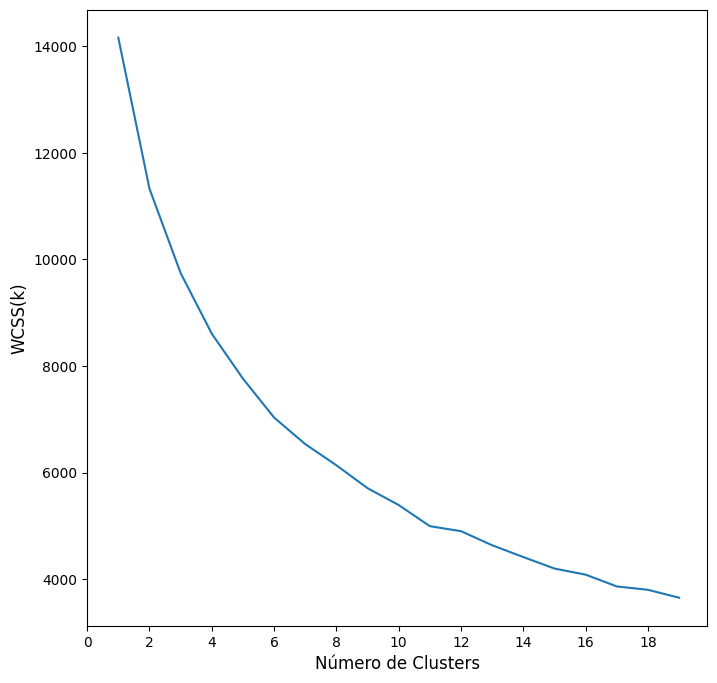

In [27]:
plt.figure(figsize=(8, 8)) 
plt.plot(range(1,cantida_kmeans), wcss)
#plt.plot([18, 18], [10000, 20000], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("WCSS(k)", fontsize=12)
plt.xticks(np.arange(0, cantida_kmeans, step=2))
plt.show()

In [28]:
from sklearn.metrics import silhouette_score

# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
silhouette_list = []
for i in range(2, cantida_kmeans):
    kmeans = KMeans(n_clusters = i,       
                    init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    y = kmeans.fit_predict(df_movies_procesado)

    # Calculamos el indice de silueta
    silhouette_list.append(silhouette_score(df_movies_procesado, y, metric="euclidean")) 

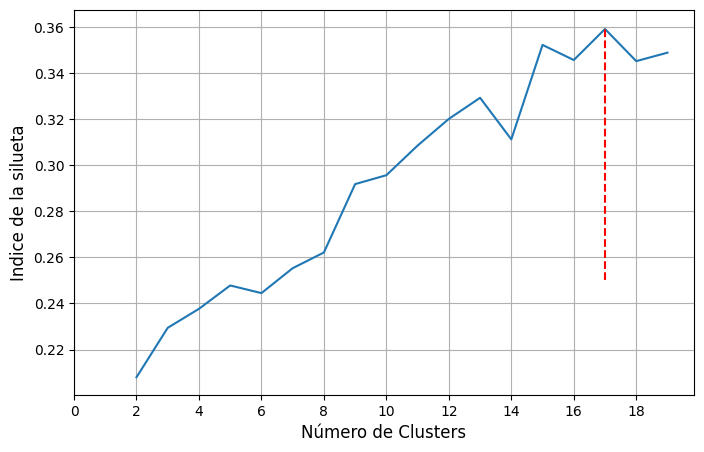

In [31]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(2,cantida_kmeans), silhouette_list)
plt.plot([17, 17], [0.25, 0.36], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Indice de la silueta", fontsize=12)
plt.xticks(np.arange(0, cantida_kmeans, step=2))
plt.grid(True)
plt.show()

## Pipeline

In [32]:
pipeline_kmeans = Pipeline([
    ('preprocessor', preprocesamiento),
    ('model', KMeans(n_clusters = 17, init="k-means++", max_iter = 300, n_init = 10, random_state = 42))
])

pipeline_kmeans

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_96758/1404001317.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


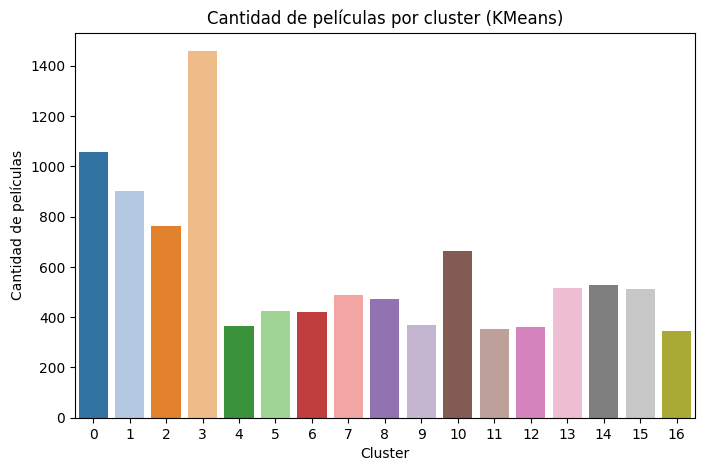

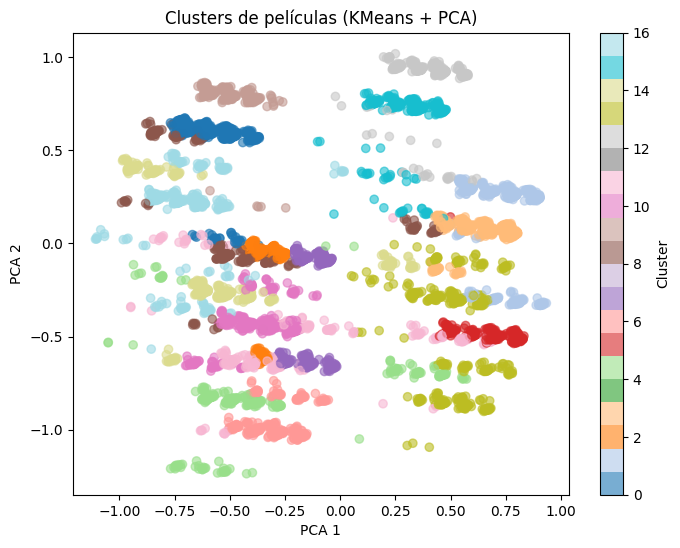

In [33]:
pipeline_kmeans.fit(df_movies_preprocesado)
labels = pipeline_kmeans.named_steps['model'].labels_
df_movies['Cluster_KMeans'] = labels
# Conteo de películas por cluster
cluster_counts = df_movies['Cluster_KMeans'].value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title('Cantidad de películas por cluster (KMeans)')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de películas')
plt.xticks(np.arange(0, 17, step=1))
plt.show()

X_cluster = pipeline_kmeans.named_steps['preprocessor'].transform(df_movies_preprocesado)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_movies['Cluster_KMeans'], cmap='tab20', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (KMeans + PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [35]:
df_movies[df_movies['Cluster_KMeans'] == 1].head()

,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Sentiment,Main_Studio,Language_group,Cluster_KMeans
5,Mia Hansen-Løve,3.77,[Drama],102.0,French,Nathalie teaches philosophy at a high school i...,"['ARTE France Cinéma', 'Detailfilm', 'CG Ciném...",0.121111,ARTE France Cinéma,Others,1
48,Charlie Kaufman,4.18,[Drama],124.0,English,"A theater director struggles with his work, an...","['Likely Story', 'Projective Testing Service',...",0.136364,Likely Story,English,1
53,Barry Jenkins,4.20,[Drama],111.0,English,"The tender, heartbreaking story of a young man...","['A24', 'Plan B Entertainment', 'PASTEL']",0.400000,A24,English,1
108,Mathieu Kassovitz,4.51,[Drama],98.0,French,After a chaotic night of rioting in a marginal...,"['Kasso Productions', 'La Sept Cinéma', 'Les P...",-0.116667,Kasso Productions,Others,1
125,Paul Thomas Anderson,4.21,[Drama],156.0,English,"Set in 1977, back when sex was safe, pleasure ...","['New Line Cinema', 'Lawrence Gordon Productio...",0.032292,New Line Cinema,English,1


# GMM

## Spherical

In [36]:
cantida_gmm = 30

# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
silhouette_list_gmm = []
for i in range(2, cantida_gmm):
    kmeans = GaussianMixture(n_components= i,
                    covariance_type="spherical",       
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    y = kmeans.fit_predict(df_movies_procesado)

    # Calculamos el indice de silueta
    silhouette_list_gmm.append(silhouette_score(df_movies_procesado, y, metric="euclidean")) 

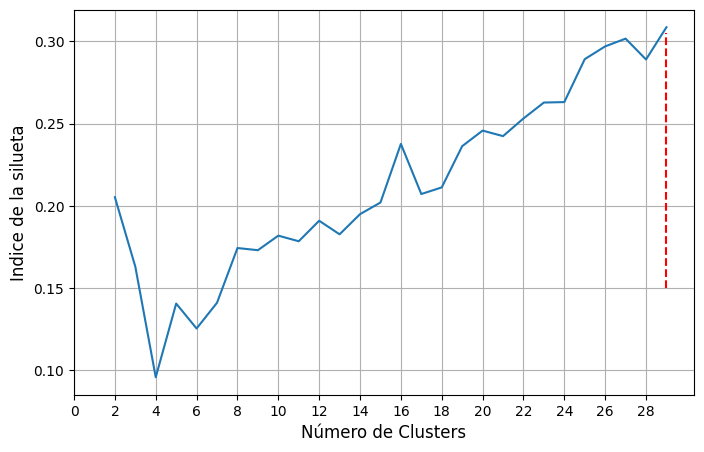

In [37]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(2, cantida_gmm), silhouette_list_gmm)
plt.plot([29, 29], [0.15, 0.305], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Indice de la silueta", fontsize=12)
plt.xticks(np.arange(0, cantida_gmm, step=2))
plt.grid(True)
plt.show()

### Pipeline GMM Spherical

In [39]:
pipeline_gmm_spherical = Pipeline([
    ('preprocessor', preprocesamiento),
    ('model', GaussianMixture(n_components=29, covariance_type="spherical", random_state=42))
])

pipeline_gmm_spherical

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_96758/3852775705.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


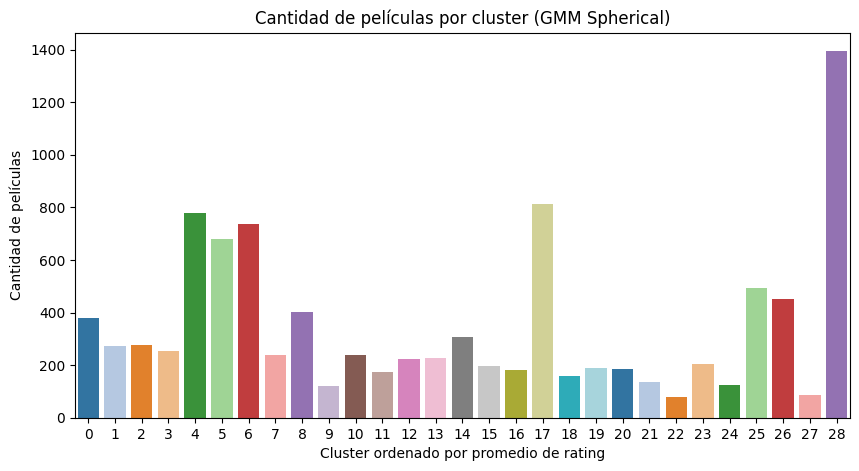

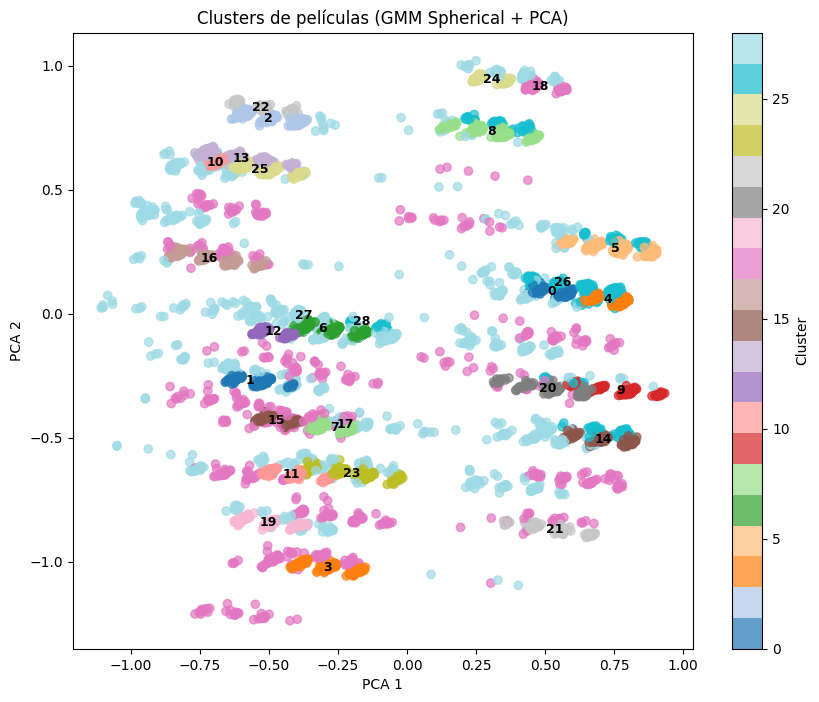

In [70]:

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pipeline_gmm_spherical.fit(df_movies_preprocesado)

# Se asignan los clusters al dataset
labels_gmm = pipeline_gmm_spherical.named_steps['model'].predict(df_movies_procesado)
df_movies['Cluster_GMM_spherical'] = labels_gmm

# Reduce a 2 dimensiones para graficar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)

# --- Conteo de películas por cluster ---
cluster_counts = df_movies['Cluster_GMM_spherical'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title('Cantidad de películas por cluster (GMM Spherical)')
plt.xlabel('Cluster ordenado por promedio de rating')
plt.ylabel('Cantidad de películas')
plt.show()

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_movies['Cluster_GMM_spherical'], cmap='tab20', alpha=0.7)

#Añadir anotaciones con el número de cluster en el centroide
centroids = []
for clust in range(df_movies['Cluster_GMM_spherical'].nunique()):
    mask = df_movies['Cluster_GMM_spherical'] == clust
    x_mean = X_pca[mask.values,0].mean()
    y_mean = X_pca[mask.values,1].mean()
    plt.text(x_mean, y_mean, str(clust), fontsize=9, fontweight='bold', color='black',
             ha='center', va='center')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (GMM Spherical + PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

## Diagonal

In [41]:
cantida_gmm = 30

# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
silhouette_list_gmm = []
for i in range(2, cantida_gmm):
    kmeans = GaussianMixture(n_components= i,
                    covariance_type="diag",       
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    y = kmeans.fit_predict(df_movies_procesado)

    # Calculamos el indice de silueta
    silhouette_list_gmm.append(silhouette_score(df_movies_procesado, y, metric="euclidean")) 

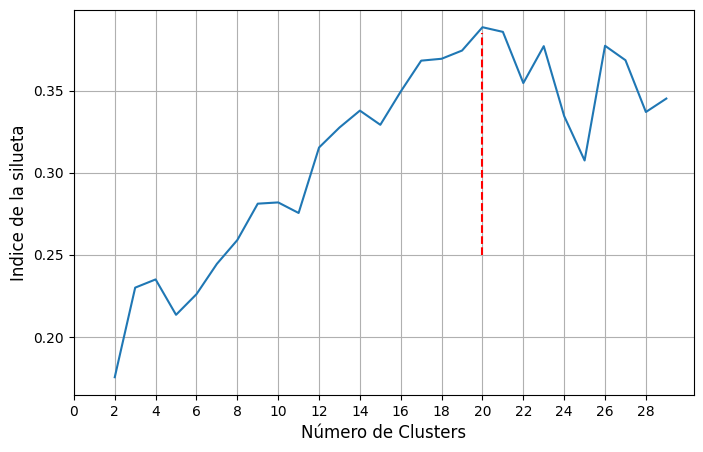

In [42]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(2, cantida_gmm), silhouette_list_gmm)
plt.plot([20, 20], [0.25, 0.385], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Indice de la silueta", fontsize=12)
plt.xticks(np.arange(0, cantida_gmm, step=2))
plt.grid(True)
plt.show()

### Pipeline GMM Diagonal

In [43]:
pipeline_gmm_diagonal = Pipeline([
    ('preprocessor', preprocesamiento),
    ('model', GaussianMixture(n_components=20, covariance_type="diag", random_state=42))
])

pipeline_gmm_diagonal

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_96758/1922090796.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


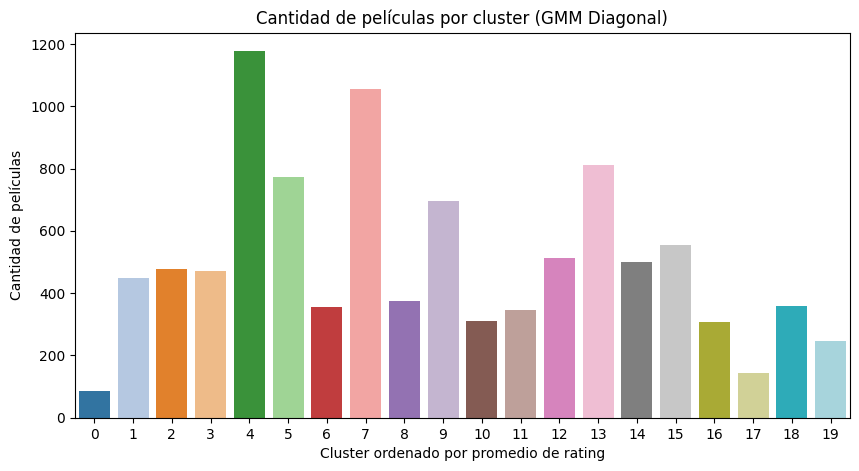

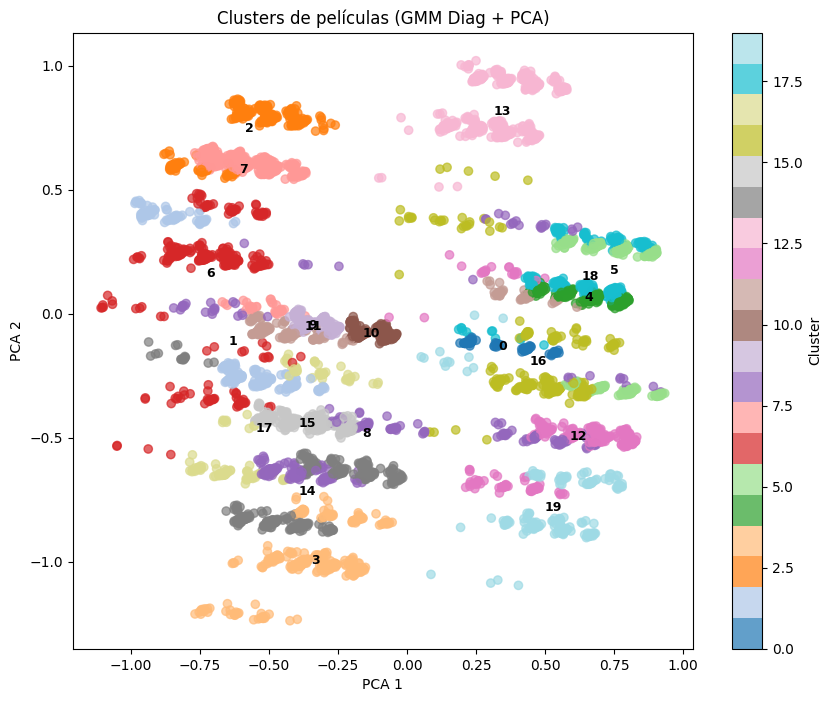

In [45]:

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pipeline_gmm_diagonal.fit(df_movies_preprocesado)

# Se asignan los clusters al dataset
labels_gmm = pipeline_gmm_diagonal.named_steps['model'].predict(df_movies_procesado)
df_movies['Cluster_GMM_diag'] = labels_gmm

# Reduce a 2 dimensiones para graficar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)

# --- Conteo de películas por cluster ---
cluster_counts = df_movies['Cluster_GMM_diag'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title('Cantidad de películas por cluster (GMM Diagonal)')
plt.xlabel('Cluster ordenado por promedio de rating')
plt.ylabel('Cantidad de películas')
plt.show()

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_movies['Cluster_GMM_diag'], cmap='tab20', alpha=0.7)

#Añadir anotaciones con el número de cluster en el centroide
centroids = []
for clust in range(df_movies['Cluster_GMM_diag'].nunique()):
    mask = df_movies['Cluster_GMM_diag'] == clust
    x_mean = X_pca[mask.values,0].mean()
    y_mean = X_pca[mask.values,1].mean()
    plt.text(x_mean, y_mean, str(clust), fontsize=9, fontweight='bold', color='black',
             ha='center', va='center')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (GMM Diag + PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

## Full

In [31]:
cantida_gmm = 30

# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
silhouette_list_gmm = []
for i in range(2, cantida_gmm):
    kmeans = GaussianMixture(n_components= i,
                    covariance_type="full",       
                    #init = "k-means++",     # Esta forma busca una inicialización que converga más rapido que incializar al azar 
                    max_iter = 300,         # El numero maximo de iteraciones
                    n_init = 10,            # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
                    random_state = 42)
    y = kmeans.fit_predict(df_movies_procesado)

    # Calculamos el indice de silueta
    silhouette_list_gmm.append(silhouette_score(df_movies_procesado, y, metric="euclidean")) 

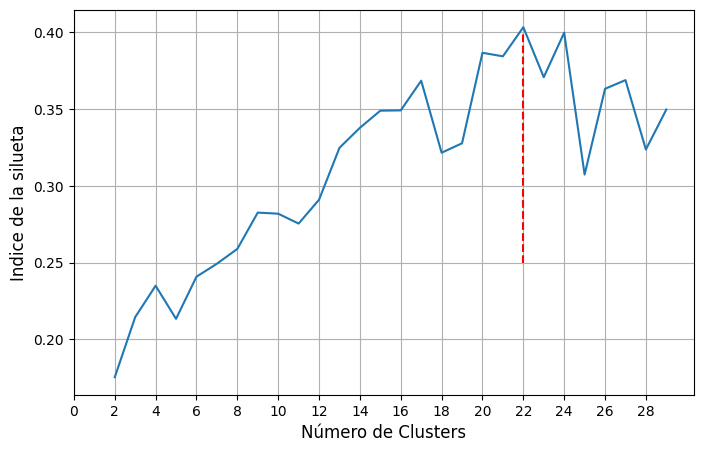

In [32]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(2, cantida_gmm), silhouette_list_gmm)
plt.plot([22, 22], [0.25, 0.4], color="r", linestyle="--")
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Indice de la silueta", fontsize=12)
plt.xticks(np.arange(0, cantida_gmm, step=2))
plt.grid(True)
plt.show()

### Pipeline GMM Full

In [50]:
pipeline_gmm_full = Pipeline([
    ('preprocessor', preprocesamiento),
    ('model', GaussianMixture(n_components=22, covariance_type="full", random_state=42))
])

pipeline_gmm_full

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numericas', ...), ('runtime', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_96758/2300441873.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


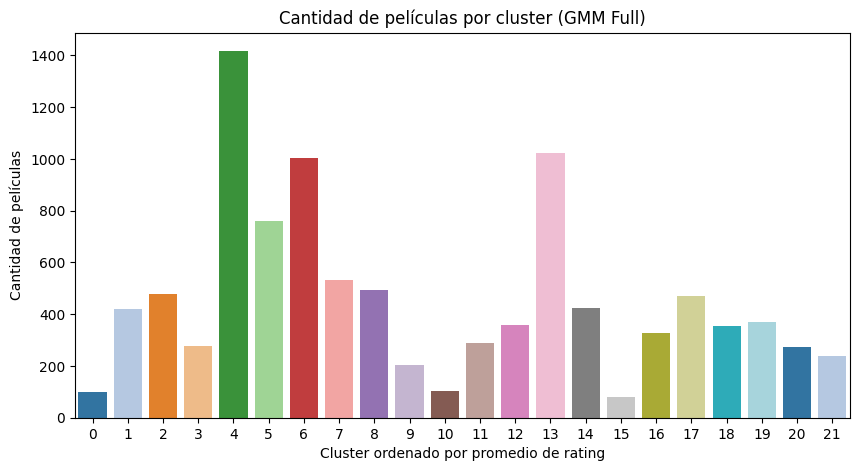

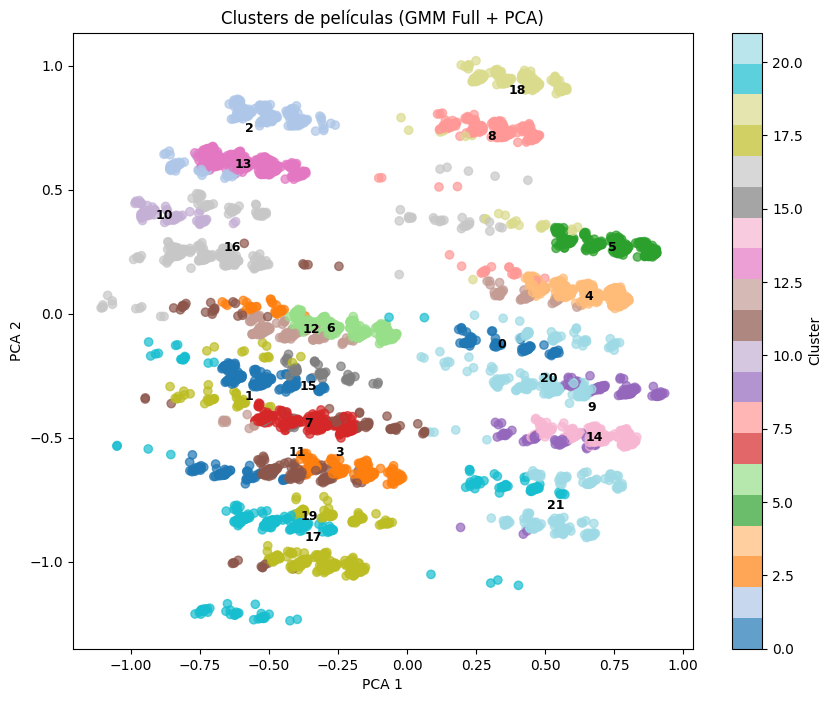

In [53]:
pipeline_gmm_full.fit(df_movies_preprocesado)

# Se asignan los clusters al dataset
labels_gmm = pipeline_gmm_full.named_steps['model'].predict(df_movies_procesado)
df_movies['Cluster_GMM_full'] = labels_gmm

# Reduce a 2 dimensiones para graficar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)

# --- Conteo de películas por cluster ---
cluster_counts = df_movies['Cluster_GMM_full'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title('Cantidad de películas por cluster (GMM Full)')
plt.xlabel('Cluster ordenado por promedio de rating')
plt.ylabel('Cantidad de películas')
plt.show()

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_movies['Cluster_GMM_full'], cmap='tab20', alpha=0.7)

#Añadir anotaciones con el número de cluster en el centroide
centroids = []
for clust in range(df_movies['Cluster_GMM_full'].nunique()):
    mask = df_movies['Cluster_GMM_full'] == clust
    x_mean = X_pca[mask.values,0].mean()
    y_mean = X_pca[mask.values,1].mean()
    plt.text(x_mean, y_mean, str(clust), fontsize=9, fontweight='bold', color='black',
             ha='center', va='center')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters de películas (GMM Full + PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [55]:
df_movies[df_movies['Cluster_GMM_full'] == 1].head(20)

,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Sentiment,Main_Studio,Language_group,Cluster_KMeans,Cluster_GMM_spherical,Cluster_GMM_diag,Cluster_GMM_full
20,Edward D. Wood Jr.,2.24,"[Others, Horror]",79.0,English,"In California, an old man grieves the loss of ...",['Reynolds Pictures'],0.166667,Reynolds Pictures,English,14,1,1,1
32,David Robert Mitchell,3.45,"[Horror, Others]",101.0,English,When carefree teenager Jay sleeps with her old...,"['Two Flints', 'Northern Lights Films', 'Anima...",0.211111,Two Flints,English,14,1,1,1
66,Kuei Chih-Hung,3.78,"[Others, Action, Horror]",105.0,Cantonese,After his brother was crippled in the ring by ...,['Shaw Brothers'],0.111111,Shaw Brothers,Others,10,17,17,1
77,Ridley Scott,3.29,"[Others, Horror]",124.0,English,A team of explorers discover a clue to the ori...,"['Dune Entertainment', '20th Century Fox', 'Br...",-0.333333,Dune Entertainment,English,14,28,1,1
85,David Cronenberg,3.99,"[Others, Horror]",96.0,English,When Seth Brundle makes a huge scientific and ...,"['SLM Production Group', 'Brooksfilms']",0.050000,SLM Production Group,English,14,1,1,1
96,David Cronenberg,3.88,"[Others, Horror]",88.0,English,"As the president of a trashy TV channel, Max R...","['Guardian Trust Company', 'Filmplan Internati...",-0.266234,Guardian Trust Company,English,14,1,1,1
101,Francis Ford Coppola,3.71,"[Horror, Others]",128.0,English,"In 19th century England, Count Dracula travels...","['American Zoetrope', 'Osiris Films', 'Columbi...",0.300000,American Zoetrope,English,14,28,1,1
135,Randy Moore,2.32,"[Others, Horror]",90.0,English,In a world of fake castles and anthropomorphic...,"['Mankurt Media', 'Producers Distribution Agen...",-0.200000,Mankurt Media,English,14,1,1,1
157,Adam Wingard,1.49,"[Others, Horror]",101.0,English,A young man comes to possess a supernatural no...,"['Vertigo Entertainment', 'Lin Pictures']",0.009259,Vertigo Entertainment,English,14,28,1,1
240,"Jaume Balagueró, Paco Plaza",3.68,"[Horror, Others]",78.0,Spanish,A television reporter and cameraman follow eme...,"['Filmax', 'Castelao Productions', 'Canal+ Esp...",-0.272222,Filmax,Others,14,1,1,1


Al observar las películas que fueron asignadas al cluster Cluster_GMM = 1, se pueden notar patrones consistentes en varias características:

Género predominante:
La mayoría de las películas de este cluster pertenecen a los géneros Horror, Mystery, Fantasy, y en menor medida Science Fiction. Esto indica que el modelo GMM ha logrado agrupar películas según temáticas similares, con un enfoque en cine de suspenso, terror y fantasía.

Estudios de producción:
Los estudios principales suelen ser productoras especializadas o más pequeñas, como Shaw Brothers, Filmax o SLM Production Group. Esto sugiere que el cluster refleja también un patrón en el tipo de estudio que produce películas dentro de estos géneros.

Directores y estilos:
Se repiten varios directores conocidos en estos géneros (por ejemplo, David Cronenberg, Tobe Hooper, Wes Craven), lo que refuerza que la agrupación captura estilos similares de narrativa y enfoque cinematográfico.

Sentimiento y ratings:
Los valores de Sentiment y Average_rating son variados pero tienden a un rango medio-bajo (entre ~0 y ~0.4 en sentimiento, y 2–3.8 en rating promedio), lo que puede reflejar que estas películas tienen un público específico y críticas mixtas, común en géneros de terror o fantasía de nicho.

Coherencia del cluster:
La agrupación tiene sentido porque las películas comparten varias características clave: género, tipo de estudio y directores. Esto sugiere que el modelo GMM ha identificado un segmento homogéneo de películas de horror, fantasía y misterio, lo cual es útil si queremos hacer análisis de mercado, recomendaciones o segmentación de audiencias.

### Otros clusters...

In [66]:
df_movies[df_movies['Cluster_GMM_full'] == 2].head()

,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Sentiment,Main_Studio,Language_group,Cluster_KMeans,Cluster_GMM_spherical,Cluster_GMM_diag,Cluster_GMM_full
90,John Hughes,3.94,[Comedy],103.0,English,After high school slacker Ferris Bueller succe...,['Paramount Pictures'],0.636667,Paramount Pictures,English,9,22,2,2
127,David Wain,3.54,[Comedy],97.0,English,"The setting is Camp Firewood, the year 1981. I...","['Eureka Pictures', 'North Coast Group']",0.082143,Eureka Pictures,English,9,2,2,2
171,"Jerry Zucker, David Zucker",3.84,[Comedy],88.0,English,An ex-fighter pilot forced to take over the co...,"['Paramount Pictures', 'Howard W. Koch Product...",-0.300000,Paramount Pictures,English,9,22,2,2
180,Terry Jones,3.99,[Comedy],94.0,English,"Brian Cohen is an average young Jewish man, bu...","['Handmade Films', 'Python (Monty) Pictures Li...",-0.047917,Handmade Films,English,9,2,2,2
220,Mike Judge,3.73,[Comedy],90.0,English,A depressed white-collar worker tries hypnothe...,['20th Century Fox'],-0.025000,20th Century Fox,English,9,2,2,2


In [67]:
df_movies[df_movies['Cluster_GMM_full'] == 13].head()

,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Sentiment,Main_Studio,Language_group,Cluster_KMeans,Cluster_GMM_spherical,Cluster_GMM_diag,Cluster_GMM_full
15,Pete Docter,4.10,"[Others, Comedy]",96.0,English,Carl Fredricksen spent his entire life dreamin...,['Pixar'],0.034091,Pixar,English,0,25,7,13
22,John Hughes,3.08,"[Comedy, Others]",93.0,English,"Two unpopular teenagers, Gary and Wyatt, fail ...","['Universal Pictures', 'Silver Pictures']",0.266667,Universal Pictures,English,0,13,7,13
25,Gillian Robespierre,3.52,"[Comedy, Others]",85.0,English,"An immature, newly unemployed comic must navig...","['Sundial Pictures', 'Votiv Films', 'Rooks Nes...",0.193182,Sundial Pictures,English,0,10,7,13
33,Richard Donner,3.80,"[Others, Comedy]",114.0,English,A young teenager named Mikey Walsh finds an ol...,"['Amblin Entertainment', 'Warner Bros. Pictures']",-0.050000,Amblin Entertainment,English,0,25,7,13
37,Ivan Reitman,3.75,"[Comedy, Others]",107.0,English,After losing their academic posts at a prestig...,"['Columbia Pictures', 'Delphi Films', 'Black R...",0.083333,Columbia Pictures,English,0,13,7,13


In [68]:
df_movies[df_movies['Cluster_GMM_full'] == 11].head()

,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Sentiment,Main_Studio,Language_group,Cluster_KMeans,Cluster_GMM_spherical,Cluster_GMM_diag,Cluster_GMM_full
27,Joel Schumacher,3.66,"[Comedy, Thriller, Horror]",97.0,English,When an unsuspecting town newcomer is drawn to...,['Warner Bros. Pictures'],-0.208333,Warner Bros. Pictures,English,11,28,8,11
104,Fede Álvarez,3.32,"[Thriller, Horror]",89.0,English,A group of teens break into a blind man's home...,"['Screen Gems', 'Stage 6 Films', 'Ghost House ...",0.000000,Screen Gems,English,11,11,8,11
107,John Carpenter,3.78,"[Horror, Thriller]",91.0,English,Fifteen years after murdering his sister on Ha...,"['Compass International Pictures', 'Falcon Int...",-0.175000,Compass International Pictures,English,11,11,8,11
119,Nicolas Winding Refn,3.15,"[Thriller, Horror]",118.0,English,When aspiring model Jesse moves to Los Angeles...,"['Space Rocket Nation', 'Gaumont', 'Wild Bunch...",0.000000,Space Rocket Nation,English,11,11,8,11
212,Mike Flanagan,3.22,"[Thriller, Horror]",82.0,English,A deaf woman is stalked by a psychotic killer ...,"['Intrepid Pictures', 'Blumhouse Productions']",-0.500000,Intrepid Pictures,English,11,11,8,11


In [69]:
df_movies[df_movies['Cluster_GMM_full'] == 3].head()

,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Sentiment,Main_Studio,Language_group,Cluster_KMeans,Cluster_GMM_spherical,Cluster_GMM_diag,Cluster_GMM_full
8,Carol Reed,4.25,"[Others, Thriller]",105.0,English,"In postwar Vienna, Austria, Holly Martins, a w...",['London Films Productions'],0.012500,London Films Productions,English,7,23,14,3
54,Quentin Tarantino,4.25,"[Others, Thriller]",154.0,English,"A burger-loving hit man, his philosophical par...","['Miramax', 'A Band Apart', 'Jersey Films']",0.166667,Miramax,English,7,23,14,3
142,Alfred Hitchcock,4.37,"[Others, Thriller]",112.0,English,A wheelchair-bound photographer spies on his n...,"['Paramount Pictures', 'Patron Inc.']",0.000000,Paramount Pictures,English,7,28,14,3
156,Christopher Nolan,4.17,"[Others, Thriller]",113.0,English,Leonard Shelby is tracking down the man who ra...,"['Newmarket Films', 'Summit Entertainment', 'T...",-0.151852,Newmarket Films,English,7,23,14,3
158,Denis Villeneuve,3.61,"[Others, Thriller]",91.0,English,A mild-mannered college professor discovers a ...,"['Rhombus Media', 'Roxbury Pictures', 'Mecanis...",-0.062500,Rhombus Media,English,7,23,14,3


# Conclusiones finales

## Observaciones

Se utilizó Gaussian Mixture Models con el parámetro covariance_type="full", lo que permite a cada cluster 
tener una matriz de covarianza completa y, por ende, capturar correlaciones entre las variables.

El índice de silueta arranca bajo (k=2) y va creciendo gradualmente.

A partir de ~k=10, la silueta empieza a mejorar.

El máximo lo alcanza cerca de k=22 con un valor de ~0.40.

Después de k=22 la métrica fluctúa, pero no mejora significativamente.



## Interpretación

Un silhouette_score ≈ 0.4 es moderado (no muy fuerte). Indica que los clusters tienen cierta separación, pero también bastante solapamiento.

Si tuvieras pocas películas (ej. 500), 22 clusters sería excesivo → algunos clusters quedarían con muy pocos elementos y perderían representatividad.

Pero con 10.000 películas, un modelo de 22 clusters genera grupos de, en promedio, ~450 películas cada uno (aunque no todos quedan balanceados).

Esto permite capturar micro-segmentos: géneros híbridos, películas independientes frente a blockbusters, etc.

Para recomendaciones, esa granularidad extra es positiva, porque permite que el sistema distinga entre nichos de películas que en un modelo de 5–10 clusters quedarían mezclados.

Con Gaussian Mixture es normal que el silhouette no sea muy alto porque los clusters permiten superposición probabilística (no particiones duras como en KMeans).

## Conclusión

Considerando que el dataset cuenta con 10.000 películas, la elección de 22 clusters obtenida con Gaussian Mixture Models resulta adecuada para un sistema de recomendaciones.

Este nivel de segmentación permite capturar la diversidad de subgrupos dentro del catálogo, evitando que las películas se agrupen en categorías demasiado generales.

Además, durante el preprocesamiento se decidió descartar la variable “idioma original”, dado que más del 80% de las películas estaban en inglés, lo que hubiera sesgado la segmentación sin aportar información significativa.

Aunque el índice de silueta (~0.40) indica una separación moderada, el tamaño del dataset justifica un mayor número de clusters, ya que cada grupo sigue siendo lo suficientemente grande y representativo para mejorar la personalización de las recomendaciones.